In [17]:
# Built-in
import os
import sys

# Import
import numpy as np
import pandas as pd
import seaborn as sns
import pygeos
import geopandas as gpd
import matplotlib.pyplot as plt

# Encode
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# ML
from sklearn.tree import DecisionTreeClassifier

# Ensemble method
from sklearn.ensemble import RandomForestClassifier

# Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Metric to evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Standard scaler
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import make_pipeline

In [2]:
# Import csv and shapefiles
combine = pd.read_csv("/Users/ou/Projects/Others/data-incubator/Collision_str.csv")
clo_shp = gpd.read_file("/Users/ou/Projects/Others/data-incubator/Collision/Collisions.shp")

/Users/ou/.virtualenvs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (44,45,46,47,48,49,50,53,54,55,56,59,60,61,62,64,65,66,67,71,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
keep = [
    'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
    'INTKEY', 'LOCATION', 'EXCEPTRSNC', 'EXCEPTRSND', 'SEVERITYCO',
    'SEVERITYDE', 'COLLISIONT', 'PERSONCOUN', 'PEDCOUNT', 'PEDCYLCOUN',
    'VEHCOUNT', 'INJURIES', 'SERIOUSINJ', 'FATALITIES', 'INCDATE',
    'INCDTTM', 'JUNCTIONTY', 'SDOT_COLCO', 'SDOT_COLDE', 'INATTENTIO',
    'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTG',
    'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY',
    'CROSSWALKK', 'HITPARKEDC', 'ARTCLASS', 'OWNER', 'SEGDIR',
    'ONEWAY', 'ONEWAYDIR', 'FLOW', 'SURFACETYP', 'SURFACET_1',
    'DIRLO', 'DIRHI', 'NATIONHWYS', 'STREETTYPE', 'TRANCLASS', 'SPEEDLIMIT',
    'SEGLENGTH', 'SURFACEWID', 'PVMTCONDIN', 'PVMTCOND_1', 'SLOPE_PCT', 'ID_y'
]

# obj:
object_list = [
    'ARTCLASS', 'OWNER', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW', 'SURFACETYP', 'SURFACET_1',
    'DIRLO', 'DIRHI', 'NATIONHWYS', 'STREETTYPE', 'TRANCLASS'
]

# int:
int_list = [
    'SPEEDLIMIT', 'SEGLENGTH', 'SURFACEWID', 'PVMTCONDIN', 'PVMTCOND_1', 'SLOPE_PCT', "OBJECTID"
]

In [7]:
# Clean to one observation per ID
combine['ID'] = combine.index
counting = combine[["OBJECTID", "ID"]].groupby(["OBJECTID"]).count().reset_index()
joined = pd.merge(combine, counting, on="OBJECTID")
joined_keep = joined[keep]
joined_mean = joined_keep[joined_keep['ID_y'] > 1][int_list].groupby("OBJECTID").mean().reset_index()
joined_merge = pd.merge(joined_mean, clo_shp, how="left", on="OBJECTID")
X_org = pd.concat([joined_keep[joined_keep['ID_y'] == 1], joined_merge], sort=False)
X_org.loc[X_org['ID_y'].isna(), object_list] = "INTERSECTION_STREET"

In [8]:
# label
X_org = X_org.loc[~(X_org['SEVERITYCO'].isna())].copy().reset_index()
X_org = X_org.loc[~(X_org['SEVERITYDE'] == "Unknown")].copy().reset_index()

In [9]:
# feature engeneer useful
X_org['dangerous'] = 0
X_org.loc[X_org['SPEEDING']=="Y", 'dangerous'] = X_org.loc[X_org['SPEEDING']=="Y", 'dangerous'] + 1
X_org.loc[X_org['INATTENTIO']=="Y", 'dangerous'] = X_org.loc[X_org['INATTENTIO']=="Y", 'dangerous'] + 1
X_org.loc[X_org['ST_COLDESC']=="Vehicle going straight hits pedestrian", 'dangerous'] = X_org.loc[X_org['ST_COLDESC']=="Vehicle going straight hits pedestrian", 'dangerous'] + 1
X_org.loc[X_org['COLLISIONT']=="Pedestrian", 'dangerous'] = X_org.loc[X_org['COLLISIONT']=="Pedestrian", 'dangerous'] + 1
X_org['safe'] = 0
X_org.loc[X_org['ST_COLDESC']=="One parked--one moving", 'safe'] = X_org.loc[X_org['ST_COLDESC']=="One parked--one moving", 'safe'] + 1
X_org.loc[X_org['COLLISIONT']=="Parked Car", 'safe'] = X_org.loc[X_org['COLLISIONT']=="Parked Car", 'safe'] + 1
# time
X_org.INCDTTM = pd.to_datetime(X_org.INCDTTM).copy()
X_org.loc[:, 'year'] = X_org.INCDTTM.dt.year
X_org.loc[:, 'month'] = X_org.INCDTTM.dt.month
X_org.loc[:, 'hour'] = X_org.INCDTTM.dt.hour
# filter
X = X_org[[
    'ADDRTYPE', 'ARTCLASS', 'COLLISIONT', 'DIRHI', 'DIRLO',
    'FLOW', 'HITPARKEDC', 'INATTENTIO', 'JUNCTIONTY', 'LIGHTCOND',
    'NATIONHWYS', 'ONEWAY', 'ONEWAYDIR', 'OWNER', 'PEDCOUNT', 'PEDCYLCOUN',
    'PEDROWNOTG', 'PERSONCOUN', 'PVMTCONDIN', 'PVMTCOND_1', 'ROADCOND',
    'SEGDIR', 'SEGLENGTH',
    'SLOPE_PCT', 'SPEEDING', 'SPEEDLIMIT', 'STREETTYPE',
    'ST_COLDESC', 'SURFACETYP', 'SURFACET_1', 'SURFACEWID', 'TRANCLASS', 'UNDERINFL',
    'VEHCOUNT', 'WEATHER', 'year', 'month', 'hour'
]].copy()
y = X_org['SEVERITYCO'].astype('object')

In [10]:
# Cleaning Phase 2:
X.loc[X['UNDERINFL']=="Y", 'UNDERINFL'] = "1"
X.loc[X['UNDERINFL']=="N", 'UNDERINFL'] = "0"
X.loc[:, X.select_dtypes(include='object').columns] = X.loc[:, X.select_dtypes(include='object').columns].fillna('MISSING')
X.loc[:, X.select_dtypes(include=['float64', 'int64']).columns] = X.loc[:, X.select_dtypes(include=['float64', 'int64']).columns].fillna(0)

# only one observation has SDOT_COLCODE as NaN
num_col = [
    "PERSONCOUN", "PEDCOUNT", "PEDCYLCOUN", "VEHCOUNT", 'year', 'month', 'hour',
    'INATTENTIO', 'UNDERINFL', 'PEDROWNOTG', 'SPEEDING', 'HITPARKEDC',
    'SPEEDLIMIT', 'SEGLENGTH', 'SURFACEWID', 'PVMTCONDIN', 'PVMTCOND_1', 'SLOPE_PCT'
]
num_mask = X.columns.isin(num_col)
cat_col = X.columns[~num_mask].tolist()

binary = ['INATTENTIO', 'UNDERINFL', 'PEDROWNOTG', 'SPEEDING', 'HITPARKEDC']
for i in binary:
    X.loc[X[i] == "Y", i] = "1"
    X.loc[X[i] == "N", i] = "0"
    X.loc[X[i] == "MISSING", i] = "2"

# Fill missing values with 0
X.loc[:, num_col] = X.loc[:, num_col].apply(lambda x: x.astype(int))
X.loc[:, cat_col] = X.loc[:, cat_col].apply(lambda x: x.fillna('MISSING'))
binary_v2 = ['UNDERINFL']
X.loc[:, binary_v2] = X.loc[:, binary_v2].apply(lambda x: x.astype(object))

# Create LabelEncoder object: le
obj_list = [
    'ADDRTYPE', 'ARTCLASS', 'COLLISIONT', 'DIRHI', 'DIRLO', 'FLOW',
    'JUNCTIONTY', 'LIGHTCOND', 'NATIONHWYS', 'ONEWAY', 'ONEWAYDIR', 'OWNER',
    'ROADCOND', 'SEGDIR', 'STREETTYPE',
    'ST_COLDESC', 'SURFACETYP', 'SURFACET_1', 'TRANCLASS', 'UNDERINFL',
    'WEATHER'
]
X.loc[:, obj_list] = X.loc[:, obj_list].apply(lambda x: x.astype(str))

df = X.select_dtypes(include=['float64', 'int64'])
enc = OneHotEncoder(handle_unknown='ignore')
for i in X.select_dtypes(include='object'):
    enc_df = pd.DataFrame(enc.fit_transform(X[[i]]).toarray())
    enc_df = enc_df.add_prefix(i)
    # merge with main df on key values
    df = df.join(enc_df)

drop = [
    "OWNER4", "STREETTYPE0", "OWNER2", "OWNER3", "ST_COLDESC32", "ST_COLDESC40", "SEGDIR2",
    "ST_COLDESC56", "ST_COLDESC49", "ST_COLDESC52", "ST_COLDESC46", "ONEWAYDIR9", "SURFACET_11",
    "SURFACETYP3", "ST_COLDESC0", "ST_COLDESC35", "ST_COLDESC2", "ST_COLDESC3", "ST_COLDESC5",
    "ST_COLDESC34", "ST_COLDESC51", "ST_COLDESC22", "ARTCLASS5", "ARTCLASS4", "ST_COLDESC50",
    "SURFACETYP3", "OWNER2", "SURFACET_11", "ONEWAYDIR9",  "ARTCLASS4", "ARTCLASS5",
    "ST_COLDESC22", "ST_COLDESC0", "OWNER3", "ST_COLDESC56", "ST_COLDESC34",
    "ST_COLDESC52", "ST_COLDESC35", "ST_COLDESC51", "ST_COLDESC50", "ST_COLDESC49",
    "ST_COLDESC46", "ST_COLDESC32", "OWNER4", "ST_COLDESC40", "SEGDIR2",
    "ST_COLDESC5", "ST_COLDESC3", "STREETTYPE0", "ST_COLDESC2"
]
df2 = df.drop(columns=drop)


In [11]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.33, random_state=42)


In [12]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42, class_weight="balanced")
tree_clf.fit(X_train, y_train.values.ravel())
y_pred = tree_clf.predict(X_test)
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average=None))

[0.77248759 0.45089768 0.06602113 0.01574803]
[0.76813216 0.45388639 0.07345739 0.01769912]
0.6641979796144002
[0.77030372 0.4523871  0.06954103 0.01666667]


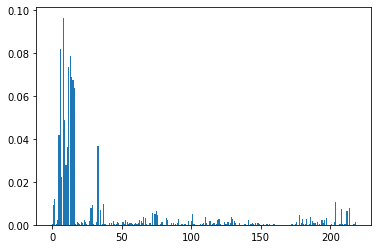

,value
SEGLENGTH,0.096508
PVMTCONDIN,0.081904
VEHCOUNT,0.078501
SURFACEWID,0.073478
year,0.068928
month,0.067695
hour,0.063849
SLOPE_PCT,0.048907
PERSONCOUN,0.042046
COLLISIONT6,0.036586


In [14]:
# Look at important features
from matplotlib import pyplot
importance = tree_clf.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

features = pd.DataFrame(importance, index=X_train.columns)
features.columns = ['value']
features.sort_values(by="value", ascending=False)

In [15]:
# Random Forest
forest_clf = RandomForestClassifier(
    random_state=42, max_depth=None,
    min_samples_split=2,
    n_estimators=200, max_features="sqrt"
)
forest_clf.fit(X_train, y_train.values.ravel())
y_pred = forest_clf.predict(X_test)
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average=None))

/Users/ou/.virtualenvs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.77227077 0.61144896 0.12       0.        ]
[0.90928437 0.39050282 0.0029383  0.        ]
0.7419843397398034
[0.83519562 0.47661484 0.00573614 0.        ]


In [18]:
# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = make_pipeline(
    StandardScaler(),
    SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
)
sgd_clf.fit(X_train, y_train.values.ravel())
y_pred = sgd_clf.predict(X_test)
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average=None))

/Users/ou/.virtualenvs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.74098584 0.74790649 0.         0.        ]
[0.98014567 0.22199783 0.         0.        ]
0.7415754161176489
[0.84394953 0.34237112 0.         0.        ]


In [19]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('forest', forest_clf), ('tree', tree_clf), ('sdg', sgd_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train.values.ravel())
y_pred = voting_clf.predict(X_test)
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average=None))

/Users/ou/.virtualenvs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7580363  0.65085933 0.07142857 0.        ]
[0.94105129 0.31769458 0.00097943 0.        ]
0.7425901525133658
[0.83968718 0.42697568 0.00193237 0.        ]
